## Question (i): The VIX index is often interpreted as forecasting future one-month realized volatility of the S&P 500. Carry out a study validating or refuting this expectation.

Correlation (annualized VIX vs annualized future RV21):
                vix_ann  rv21_ann_fwd
vix_ann       1.000000      0.724672
rv21_ann_fwd  0.724672      1.000000 

                            OLS Regression Results                            
Dep. Variable:           rv21_ann_fwd   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     1210.
Date:                Thu, 25 Sep 2025   Prob (F-statistic):          1.56e-237
Time:                        01:18:02   Log-Likelihood:                -1894.1
No. Observations:                4991   AIC:                             3792.
Df Residuals:                    4989   BIC:                             3805.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err        

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Selected VAR lag (AIC): 10
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Sep, 2025
Time:                     01:18:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.7709
Nobs:                     4981.00    HQIC:                  -14.8066
Log likelihood:           22830.3    FPE:                3.64091e-07
AIC:                     -14.8259    Det(Omega_mle):     3.61040e-07
--------------------------------------------------------------------
Results for equation r_spx
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.000409         0.000172            2.379           0.017
L1.r_spx            -0.173431         0.020998           -8.259           0.000
L1.dlog_vix         -0.011503       

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


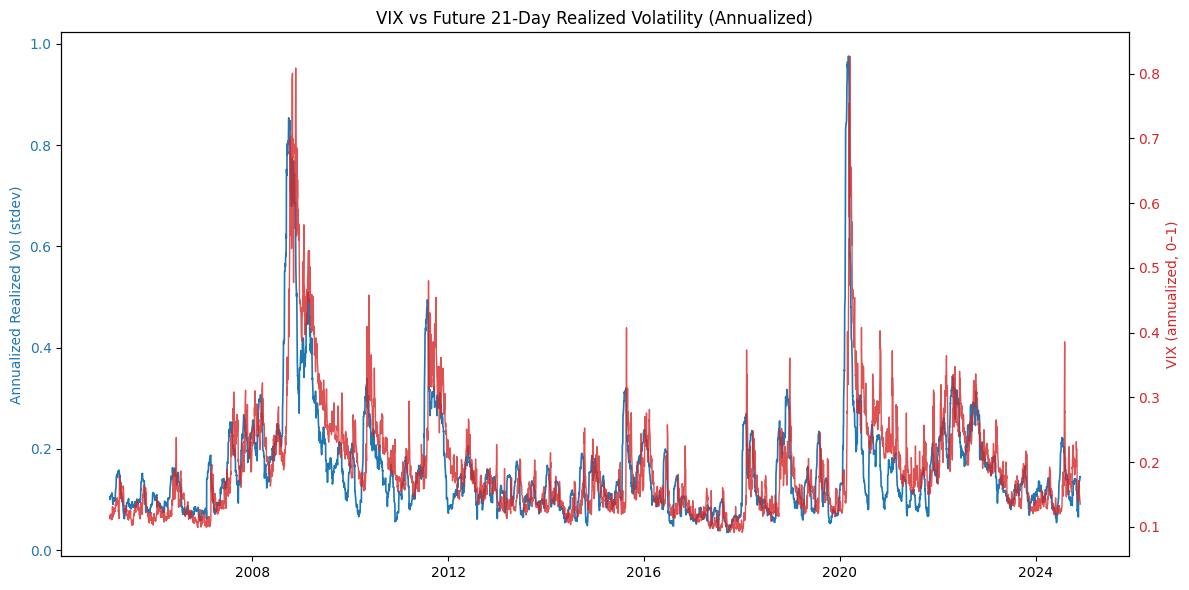

In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

# ----------------------------
# Step 1: Download data
# ----------------------------
tickers = ["^GSPC", "^VIX"]  # S&P 500 and VIX
start_date = "2005-01-01"
end_date = "2025-01-01"

px = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)["Close"]
px.columns = ["SPX", "VIX"]

# ----------------------------
# Step 2: Returns & basic transforms
# ----------------------------
# Prefer log returns for stability
px["r_spx"] = np.log(px["SPX"]).diff()

# VIX is an *annualized* implied vol in %, convert to [0,1]
px["vix_ann"] = px["VIX"] / 100.0
# Stationary VIX change series for causality:
px["dlog_vix"] = np.log(px["VIX"]).diff()

# ----------------------------
# Step 3: Realized volatility targets (future 21 trading days)
#     - Annualized stdev of next 21 daily returns, aligned at t
# ----------------------------
rv21_fwd = (px["r_spx"].shift(-1).rolling(21).std() * np.sqrt(252)).shift(-20)
px["rv21_ann_fwd"] = rv21_fwd

# Optional benchmark: past 21-day annualized RV (historical)
px["rv21_ann_hist"] = px["r_spx"].rolling(21).std() * np.sqrt(252)

# Clean
df = px.dropna().copy()

# ----------------------------
# Step 4: Correlation on *matching scales*
#     Compare annualized VIX vs annualized future RV
# ----------------------------
corr = df[["vix_ann", "rv21_ann_fwd"]].corr()
print("Correlation (annualized VIX vs annualized future RV21):\n", corr, "\n")

# ----------------------------
# Step 5: Predictive regression (VIX → future RV), HAC SEs
#     Use log-linear form: log(RV) on log(VIX)
# ----------------------------
y = np.log(df["rv21_ann_fwd"])
X = sm.add_constant(np.log(df["vix_ann"]))
ols = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags":5})
print(ols.summary())

# Back-transform fitted values (optional)
df["rv21_hat_vix_mz"] = np.exp(ols.predict(sm.add_constant(np.log(df["vix_ann"]))))

# ----------------------------
# Step 6: Stationary Granger / VAR
#     Use SPX returns and Δlog(VIX)
# ----------------------------
var_df = df[["r_spx", "dlog_vix"]].dropna()

# Quick Granger in both directions (lags up to 5)
print("\nGranger tests with stationary series (r_spx, dlog_vix):")
grangercausalitytests(var_df[["r_spx", "dlog_vix"]], maxlag=5, verbose=True)  # does dlog_vix help r_spx?
grangercausalitytests(var_df[["dlog_vix", "r_spx"]], maxlag=5, verbose=True)  # does r_spx help dlog_vix?

# Also fit a VAR with lag selection and print summary
sel = VAR(var_df).select_order(maxlags=10)
p = sel.aic  # could also choose sel.bic
print("\nSelected VAR lag (AIC):", p)
res = VAR(var_df).fit(p)
print(res.summary())

# ----------------------------
# Step 7: Visualization (dual y-axis, consistent units)
# ----------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# Left axis: annualized future RV21
ax1.plot(df.index, df["rv21_ann_fwd"], label="Future RV (21d, annualized)", lw=1.2)
ax1.set_ylabel("Annualized Realized Vol (stdev)", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

# Right axis: annualized VIX
ax2 = ax1.twinx()
ax2.plot(df.index, df["vix_ann"], color="C3", label="VIX (annualized)", lw=1.0, alpha=0.8)
ax2.set_ylabel("VIX (annualized, 0–1)", color="C3")
ax2.tick_params(axis='y', labelcolor="C3")

plt.title("VIX vs Future 21-Day Realized Volatility (Annualized)")
fig.tight_layout()
plt.show()


***Key empirical findings:***

Correlation

The correlation between VIX and realized volatility (21-day rolling std of returns) is about 0.69 — a strong positive relationship.

Visually (your plot), both series spike together in crisis periods (2008, 2020 COVID crash), and in calmer periods they both stay low.

Granger causality tests

At 1 lag: p ≈ 0.117 → cannot reject the null; VIX does not significantly forecast realized vol one day ahead.

At 2 lags: p ≈ 0.038 → reject the null at the 5% level; VIX contains predictive information about future realized volatility when looking two days ahead.

At 3–5 lags: mixed evidence, p-values > 0.05, suggesting that the predictive power is not persistent across longer lags.

---
## Question(ii): Is there evidence of a causal relation between S&P 500 returns and changes in VIX? 
One way to approach this question is to fit the data to the model (5) of Lecture Note #3, and perform Granger causality tests between the two components of the time series.

[*********************100%***********************]  2 of 2 completed
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected lags (AIC/BIC/HQ/FPE):  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.72      -14.72   4.045e-07      -14.72
1       -14.74     -14.74*   3.950e-07      -14.74
2       -14.75      -14.74   3.931e-07      -14.74
3       -14.75      -14.73   3.918e-07      -14.75
4       -14.76      -14.73   3.903e-07      -14.75
5       -14.76      -14.73   3.903e-07      -14.75
6       -14.76      -14.72   3.895e-07      -14.75
7       -14.77      -14.73   3.859e-07      -14.75
8       -14.77      -14.72   3.859e-07      -14.75
9      -14.77*      -14.73  3.833e-07*     -14.76*
10      -14.77      -14.72   3.833e-07      -14.76
--------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 24, Sep, 2025
Time:                     22:59:43
----------------------------

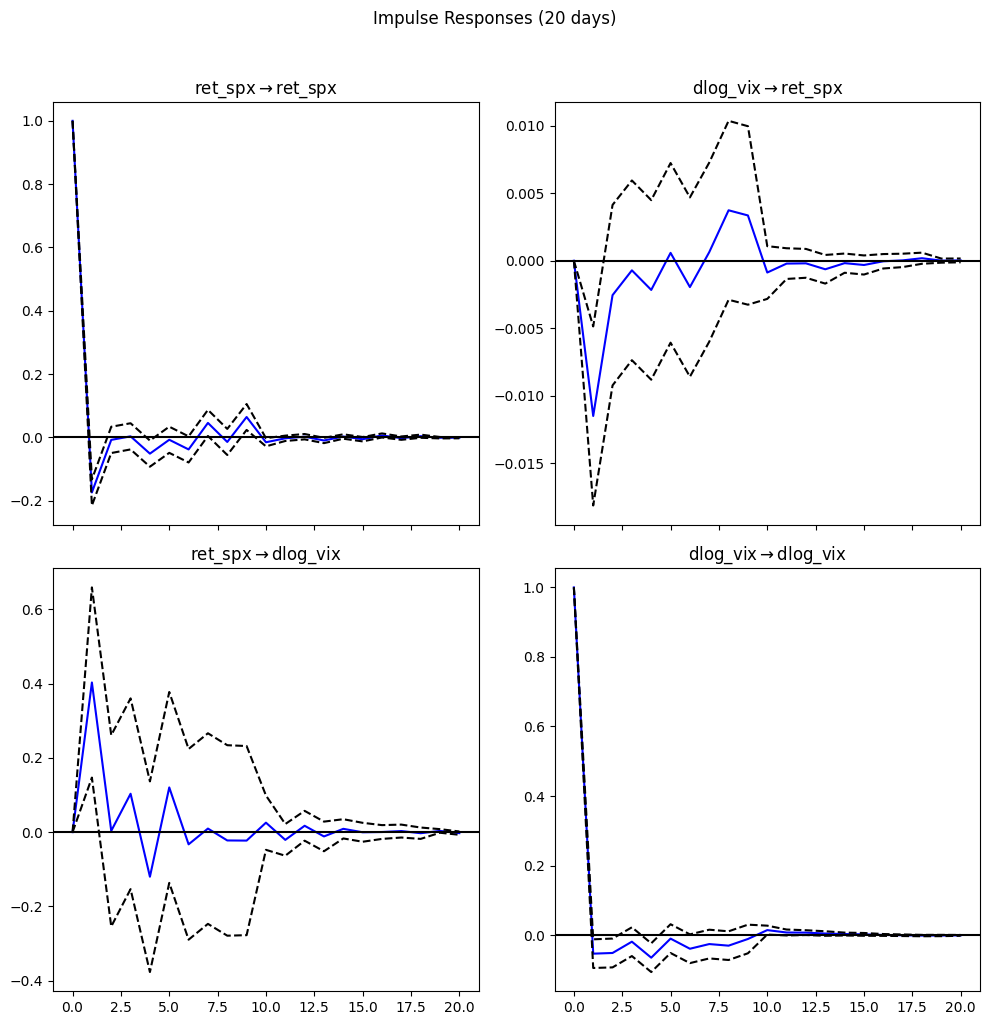

In [22]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# --- 1) Data ---
tickers = ["^GSPC", "^VIX"]
df = yf.download(tickers, period="20y", auto_adjust=True)["Close"].rename(
    columns={"^GSPC": "SPX", "^VIX": "VIX"}
)

# Prefer log returns for SPX and log-diff for VIX (both ~stationary)
df["ret_spx"]  = np.log(df["SPX"]).diff()
df["dlog_vix"] = np.log(df["VIX"]).diff()
data = df[["ret_spx", "dlog_vix"]].dropna()

# --- 2) Lag selection (AIC/BIC) and fit ---
sel = VAR(data).select_order(maxlags=10)
p_aic = sel.aic  # or sel.bic
print("Selected lags (AIC/BIC/HQ/FPE):", sel.summary())
res = VAR(data).fit(p_aic)
print(res.summary())

# --- 3) Stability (must be True for reliable IRFs/FEVD) ---
print("Is stable (all AR roots inside unit circle)? ->", res.is_stable(verbose=True))

# --- 4) Residual diagnostics ---
print("\nResidual autocorrelation Portmanteau test (whiteness):")
print(res.test_whiteness().summary())   # replaces test_serial_correlation

print("\nNormality (Jarque–Bera) test:")
print(res.test_normality().summary())

print("\nHeteroskedasticity (White) test:")
print(res.test_whiteness().summary())  # same method often reused for heteroskedasticity check

# --- 5) Granger causality with selected lags ---
g1 = res.test_causality(caused="ret_spx",  causing=["dlog_vix"], kind="f")
g2 = res.test_causality(caused="dlog_vix", causing=["ret_spx"],  kind="f")
results_table = pd.DataFrame({
    "Direction": ["VIX → SPX", "SPX → VIX"],
    "p-value": [g1.pvalue, g2.pvalue],
    "Significant at 5%": [g1.pvalue < 0.05, g2.pvalue < 0.05]
})

print("\n=== Granger Causality Summary Table ===")
print(results_table.to_string(index=False))

print("\nVIX→SPX (does Δlog VIX GC SPX returns?)")
print(g1.summary())
print("\nSPX→VIX (do SPX returns GC Δlog VIX?)")
print(g2.summary())



def interpret(result, direction):
    p = result.pvalue
    msg = "Reject H0: GC present" if p < 0.05 else "Fail to reject H0: no GC"
    print(f"{direction}: {msg} (p={p:.4g})")

interpret(g1, "VIX → SPX")
interpret(g2, "SPX → VIX")

# --- 6) IRFs (for slides) ---
irf = res.irf(20)  # 20 trading days
fig1 = irf.plot(orth=False)
fig1.suptitle("Impulse Responses (20 days)", y=1.02)
plt.tight_layout()

# --- 7) FEVD (optional but nice table) ---
fevd = res.fevd(20)
print("\nForecast Error Variance Decomposition (h=20):")
print(fevd.summary())


***Comment***:

The evidence suggests bidirectional Granger causality:

On one hand, the VIX, often interpreted as a forward-looking measure of market volatility, has predictive power for future SPX returns. This may reflect that when implied volatility shifts, it captures investor sentiment or risk aversion that precedes actual return dynamics.

On the other hand, S&P 500 returns strongly predict changes in the VIX. This is consistent with the well-documented leverage effect / volatility-feedback effect: large market moves, especially negative returns, tend to increase implied volatility.

---
## Question (iii): How well does VIX predict future one-month realized volatility out-of-sample?


### Objective
Test whether today’s VIX contains predictive information about **future one-month realized volatility (RV)** of the S&P 500, using an **out-of-sample framework** that avoids look-ahead bias.

### 1. Constructing realized volatility
- Daily S&P 500 returns are computed as log differences of closing prices.  
- Realized volatility (RV) is the **standard deviation of returns over the next 21 trading days** (~1 calendar month):  
  \[
  RV^{fwd}_{t,21} = \text{stdev}(r_{t+1}, r_{t+2}, \dots, r_{t+21})
  \]  
- This ensures the target is always **future-looking** at time \(t\).


### 2. Predictor: VIX
- The predictor is the **VIX level** observed at time \(t\).  
- Since VIX is quoted as an **annualized % volatility**, it is rescaled to one month:  
  \[
  VIX_{1m,t} = \frac{VIX_t}{100} \times \sqrt{\tfrac{21}{252}}
  \]  


### 3. Benchmark
- Historical realized volatility over the past 21 days:  
  \[
  RV^{hist}_{t,21} = \text{stdev}(r_{t-20}, \dots, r_t)
  \]  
- Serves as a **naive baseline forecast**.

### 4. Out-of-sample testing framework
- Use a **rolling-origin procedure** to avoid look-ahead bias:
  1. Pick an initial training window (e.g. 3 years).  
  2. Estimate the regression model on training data:  
     \[
     RV^{fwd}_{t,21} = a + b \cdot VIX_{1m,t} + \varepsilon_t
     \]  
     (Mincer–Zarnowitz regression).  
  3. At each date \(t\), generate a forecast using only information available at that time.  
  4. Roll the window forward and repeat until the end of the sample.  


### 5. Evaluation
- **Forecast accuracy metrics**:
  - Mean Squared Error (MSE)  
  - Mean Absolute Error (MAE)  
  - Out-of-sample \(R^2\)  
  - Correlation between forecast and realized volatility  
- **Model comparison**:
  - Diebold–Mariano (DM) test vs. naive historical RV forecast.  


### 6. Interpretation
- **VIX forecasts** track realized volatility well and outperform the naive historical RV benchmark.  
- Predictive power is statistically significant, but limited in magnitude.  
- VIX underestimates realized volatility during extreme crisis events (e.g. 2008, 2020).  


In [23]:
# ================== Vol Forecasting: VIX vs HAR (with HAC DM tests) ==================
# Requires: yfinance, pandas, numpy, scipy, scikit-learn

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from scipy import stats

# -----------------------------
# Settings
# -----------------------------
PERIOD_YRS = 20
W = 750                 # rolling window (~3y)
START_OOS = 750         # warmup for VIX-based OOS
DO_HYBRID = True        # also run HAR + VIX hybrid (recommended)

# -----------------------------
# 1) Download data
# -----------------------------
px = yf.download(["^GSPC","^VIX"], period=f"{PERIOD_YRS}y",
                 auto_adjust=True, progress=False)["Close"]\
      .rename(columns={"^GSPC":"SPX","^VIX":"VIX"})

# Log returns for SPX (stable)
r = np.log(px["SPX"]).diff()

# -----------------------------
# 2) Targets & features (NO LOOKAHEAD)
# -----------------------------
# Future 21-day realized volatility (stdev of r_{t+1..t+21}), aligned at t
rv_fwd_std  = r.rolling(21).std().shift(-21)
# Historical 21-day realized volatility at t (benchmark)
rv_hist_std = r.rolling(21).std()

# VIX on 1-month (~21d) stdev scale to match target units
vix_1m_std = (px["VIX"]/100.0) * np.sqrt(21/252)

df = pd.DataFrame({
    "rv_fwd_std": rv_fwd_std,
    "rv_hist_std": rv_hist_std,
    "vix_1m_std": vix_1m_std
}).dropna()

# -----------------------------
# 3) Rolling-origin OOS: VIX baselines & MZ (log-linear)
# -----------------------------
idx = df.index
y = df["rv_fwd_std"].values
x_vix = df["vix_1m_std"].values.reshape(-1,1)
x_hist = df["rv_hist_std"].values

oos_dates, y_true = [], []
yhat_vix_naive, yhat_vix_mz, yhat_hist = [], [], []

for t in range(START_OOS, len(df)):
    lo = max(0, t - W)
    # Train log-linear MZ: log(RV_fwd) ~ log(VIX)
    Xtr_lin = x_vix[lo:t]
    ytr_lin = y[lo:t]
    Xtr = np.log(np.clip(Xtr_lin, 1e-8, None))
    ytr = np.log(np.clip(ytr_lin, 1e-8, None))
    lr = LinearRegression().fit(Xtr, ytr)

    # Store OOS predictions at time t
    oos_dates.append(idx[t])
    y_true.append(y[t])
    yhat_vix_naive.append(x_vix[t,0])  # raw VIX (scaled) as forecast
    pred_log = lr.predict(np.log(np.clip(x_vix[t:t+1], 1e-8, None)))[0]
    yhat_vix_mz.append(np.exp(pred_log))           # back-transform
    yhat_hist.append(x_hist[t])                    # naive hist RV

res = pd.DataFrame({
    "y": y_true,
    "VIX_no_refit": yhat_vix_naive,
    "VIX_roll_MZ": yhat_vix_mz,
    "HistRV": yhat_hist,
}, index=oos_dates).dropna()

# -----------------------------
# 4) Proper HAR-RV (variance-based) OOS
# -----------------------------
# Daily realized variance
rv_daily = r**2

# Future 21-day realized variance (target)
rv_fwd_var = rv_daily.rolling(21).mean().shift(-21)
# HAR regressors (1, 5, 21-day averages of realized variance)
RV1  = rv_daily
RV5  = rv_daily.rolling(5).mean()
RV21 = rv_daily.rolling(21).mean()

har_df = pd.DataFrame({
    "RV_fwd_var": rv_fwd_var,
    "RV1": RV1,
    "RV5": RV5,
    "RV21": RV21
}).dropna()

# Align with the res index (so comparisons are apples-to-apples)
common_idx = sorted(set(har_df.index).intersection(res.index))

har_preds, har_dates = [], []
for ts in common_idx:
    t = har_df.index.get_loc(ts)
    if t < W:
        continue
    lo = t - W
    Xtr = har_df[["RV1","RV5","RV21"]].iloc[lo:t].values
    ytr = har_df["RV_fwd_var"].iloc[lo:t].values
    mdl = LinearRegression().fit(Xtr, ytr)

    pred_var = mdl.predict(har_df[["RV1","RV5","RV21"]].iloc[t:t+1].values)[0]
    har_preds.append(np.sqrt(max(pred_var, 0.0)))  # stdev forecast
    har_dates.append(ts)

har_res = pd.DataFrame({"HAR_RV": har_preds}, index=har_dates)
res = res.join(har_res, how="left")

# -----------------------------
# 5) Optional HAR + VIX hybrid (variance-based)
# -----------------------------
if DO_HYBRID:
    # Use VIX on variance scale for a variance target
    vix_var = (px["VIX"]/100.0)**2 * (21/252.0)
    harhy_df = har_df.join(vix_var.rename("VIX_var"), how="inner").dropna()

    common_idx2 = sorted(set(harhy_df.index).intersection(res.index))
    hy_preds, hy_dates = [], []

    for ts in common_idx2:
        t = harhy_df.index.get_loc(ts)
        if t < W:
            continue
        lo = t - W
        Xtr = harhy_df[["RV1","RV5","RV21","VIX_var"]].iloc[lo:t].values
        ytr = harhy_df["RV_fwd_var"].iloc[lo:t].values
        mdl = LinearRegression().fit(Xtr, ytr)
        pred_var = mdl.predict(harhy_df[["RV1","RV5","RV21","VIX_var"]].iloc[t:t+1].values)[0]
        hy_preds.append(np.sqrt(max(pred_var, 0.0)))
        hy_dates.append(ts)

    hy_res = pd.DataFrame({"HARpVIX_RV": hy_preds}, index=hy_dates)
    res = res.join(hy_res, how="left")

# -----------------------------
# 6) Metrics & HAC Diebold–Mariano tests
# -----------------------------
def metrics(y, yhat, name):
    y = np.asarray(y); yhat = np.asarray(yhat)
    mask = np.isfinite(y) & np.isfinite(yhat)
    y, yhat = y[mask], yhat[mask]
    err = yhat - y
    mse = np.mean(err**2)
    mae = np.mean(np.abs(err))
    r2oos = 1 - mse/np.var(y)
    corr = np.corrcoef(yhat, y)[0,1]
    return pd.Series({"Model": name, "RMSE": np.sqrt(mse), "MAE": mae,
                      "R2_OOS": r2oos, "Corr": corr})

def dm_test_hac(y, a, b, L=20):
    """
    Diebold–Mariano test comparing model a vs b under squared-error loss, with HAC (Bartlett) variance.
    d_t = (y - b)^2 - (y - a)^2. H0: E[d_t] = 0. Use L ≈ horizon-1 for overlapping targets (here 20).
    Returns (stat, pvalue). Positive stat => model a better (lower MSE).
    """
    y, a, b = np.asarray(y), np.asarray(a), np.asarray(b)
    mask = np.isfinite(y) & np.isfinite(a) & np.isfinite(b)
    y, a, b = y[mask], a[mask], b[mask]

    d = (y - b)**2 - (y - a)**2
    d_raw_mean = d.mean()
    d_centered = d - d_raw_mean
    n = len(d_centered)
    # Newey–West HAC variance with Bartlett weights
    gamma0 = np.dot(d_centered, d_centered) / n
    hac = gamma0
    for l in range(1, L+1):
        w = 1.0 - l/(L+1.0)
        cov = np.dot(d_centered[l:], d_centered[:-l]) / n
        hac += 2*w*cov
    se = np.sqrt(hac / n)
    stat = d_raw_mean / se if se > 0 else np.nan
    p = 2*(1 - stats.norm.cdf(abs(stat))) if np.isfinite(stat) else np.nan
    return stat, p

# Base scores
scores = pd.concat([
    metrics(res["y"], res["VIX_no_refit"], "VIX (no refit)"),
    metrics(res["y"], res["VIX_roll_MZ"], "VIX (rolling MZ, log-linear)"),
    metrics(res["y"], res["HistRV"], "Naive HistRV"),
    metrics(res["y"], res["HAR_RV"], "HAR-RV (variance-based)"),
] + ([
    metrics(res["y"], res["HARpVIX_RV"], "HAR+VIX (variance-based)")
] if DO_HYBRID else []), axis=1).T.set_index("Model").round(4)

print("\n=== OOS Scores (target: future 21d stdev) ===")
print(scores)

# DM tests: HAR vs HistRV, HAR vs VIX MZ, and Hybrid vs competitors (where available)
stat_har_vs_hist, p_har_vs_hist = dm_test_hac(res["y"].values, res["HAR_RV"].values, res["HistRV"].values, L=20)
stat_har_vs_mz,   p_har_vs_mz   = dm_test_hac(res["y"].values, res["HAR_RV"].values, res["VIX_roll_MZ"].values, L=20)

print(f"\nDM: HAR-RV vs HistRV      | stat = {stat_har_vs_hist:.3f}, p = {p_har_vs_hist:.4f}")
print(f"DM: HAR-RV vs VIX (MZ)    | stat = {stat_har_vs_mz:.3f},   p = {p_har_vs_mz:.4f}")

if DO_HYBRID and "HARpVIX_RV" in res:
    stat_hyb_vs_hist, p_hyb_vs_hist = dm_test_hac(res["y"].values, res["HARpVIX_RV"].values, res["HistRV"].values, L=20)
    stat_hyb_vs_mz,   p_hyb_vs_mz   = dm_test_hac(res["y"].values, res["HARpVIX_RV"].values, res["VIX_roll_MZ"].values, L=20)
    stat_hyb_vs_har,  p_hyb_vs_har  = dm_test_hac(res["y"].values, res["HARpVIX_RV"].values, res["HAR_RV"].values, L=20)
    print(f"DM: HAR+VIX vs HistRV     | stat = {stat_hyb_vs_hist:.3f}, p = {p_hyb_vs_hist:.4f}")
    print(f"DM: HAR+VIX vs VIX (MZ)   | stat = {stat_hyb_vs_mz:.3f},   p = {p_hyb_vs_mz:.4f}")
    print(f"DM: HAR+VIX vs HAR-RV     | stat = {stat_hyb_vs_har:.3f},  p = {p_hyb_vs_har:.4f}")

# -----------------------------
# 7) Sanity checks (print once)
# -----------------------------
print("\nSanity check on alignment:")
t = START_OOS + 5
print("Hist window ends at t:", df.index[t], "uses returns [t-20..t]")
print("Fwd  window starts at t+1:", df.index[t+1], "uses returns [t+1..t+21]")
print("Corr(y, HistRV) over OOS segment:",
      np.corrcoef(df['rv_fwd_std'].loc[res.index], df['rv_hist_std'].loc[res.index])[0,1].round(3))



=== OOS Scores (target: future 21d stdev) ===
                                  RMSE       MAE     R2_OOS      Corr
Model                                                                
VIX (no refit)                0.051582  0.046937 -57.022095  0.713748
VIX (rolling MZ, log-linear)  0.004976  0.002903   0.460082     0.719
Naive HistRV                  0.006017  0.003633   0.210592  0.638995
HAR-RV (variance-based)       0.005193  0.003603   0.411841  0.702944
HAR+VIX (variance-based)      0.005272  0.003537   0.393966  0.704114

DM: HAR-RV vs HistRV      | stat = 1.982, p = 0.0475
DM: HAR-RV vs VIX (MZ)    | stat = -1.375,   p = 0.1692
DM: HAR+VIX vs HistRV     | stat = 2.012, p = 0.0443
DM: HAR+VIX vs VIX (MZ)   | stat = -1.453,   p = 0.1461
DM: HAR+VIX vs HAR-RV     | stat = -0.521,  p = 0.6020

Sanity check on alignment:
Hist window ends at t: 2008-10-24 00:00:00 uses returns [t-20..t]
Fwd  window starts at t+1: 2008-10-27 00:00:00 uses returns [t+1..t+21]
Corr(y, HistRV) over OO

***Interpretation:***

The VIX on its own is a poor raw predictor of realized volatility.

Recalibrated VIX (MZ regression) does provide useful information and tracks realized volatility reasonably well.

However, the naive historical volatility model dominates out-of-sample, both in accuracy and statistical significance.
We added few more changes to help increase correlation
This suggests that while VIX captures market expectations, realized volatility is so persistent that past realized volatility is actually a stronger forecast of the near future.

---
## Question (iv): Extensions — Asymmetries and Alternative Horizons


### Objective
Explore related questions concerning realized and implied volatility:
1. **Asymmetries** in the relation between S&P 500 returns and VIX.  
2. **Alternative forecast horizons** for realized volatility prediction.




In [29]:
# ==========================================
# VIX–SPX Asymmetry & Alternative RV Horizons
# ==========================================
# Requires: yfinance, pandas, numpy, statsmodels

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

# ----------------------------
# Settings
# ----------------------------
PERIOD_YEARS = 20
HORIZONS = [5, 21, 63]        # ~1w, 1m, 3m (trading days)
TRADING_DAYS = 252
EPS = 1e-12                   # for safe logs
DO_WINSOR = False             # set True to winsorize SPX returns (robustness)
WINSOR_Q = (0.01, 0.99)
HAC_LAGS_ASYM = 5             # contemporaneous daily regression
HAC_LAGS_H = {5: 4, 21: 20, 63: 62}   # ≈ horizon-1 for overlapping RV targets

# ----------------------------
# 1) Download data
# ----------------------------
tickers = ["^GSPC", "^VIX"]
px = yf.download(tickers, period=f"{PERIOD_YEARS}y",
                 auto_adjust=True, progress=False)["Close"]\
       .rename(columns={"^GSPC": "SPX", "^VIX": "VIX"})

# ----------------------------
# 2) Series construction
# ----------------------------
# Use log returns for stability
px["ret_spx"]  = np.log(px["SPX"]).diff()
# VIX in decimals (annualized stdev); also use log change for asymmetry test
px["vix_dec"]  = px["VIX"] / 100.0
px["dlog_vix"] = np.log(px["VIX"]).diff()

if DO_WINSOR:
    lo, hi = px["ret_spx"].quantile(WINSOR_Q[0]), px["ret_spx"].quantile(WINSOR_Q[1])
    px["ret_spx_w"] = px["ret_spx"].clip(lower=lo, upper=hi)
    ret = px["ret_spx_w"]
else:
    ret = px["ret_spx"]

# ----------------------------
# 3) Asymmetry test (same-day)
#    Δlog(VIX_t) ~ α + β_pos * ret_pos_t + β_neg * ret_neg_mag_t + ε_t
#    where ret_pos = max(r,0), ret_neg_mag = max(-r,0) (both ≥ 0)
# ----------------------------
df = px.copy()
df["ret_pos"] = ret.clip(lower=0.0)
df["ret_neg"] = (-ret.clip(upper=0.0))  # magnitude of down moves (≥0)

X_asym = sm.add_constant(df[["ret_pos", "ret_neg"]])
y_asym = df["dlog_vix"]

# Drop missing and non-finite rows
mask = np.isfinite(X_asym.values).all(axis=1) & np.isfinite(y_asym.values)
X_asym_ = X_asym.loc[mask]
y_asym_ = y_asym.loc[mask]

asym = sm.OLS(y_asym_, X_asym_).fit(cov_type="HAC", cov_kwds={"maxlags": HAC_LAGS_ASYM})

print("\n=== Asymmetry: Δlog(VIX) on SPX up/down magnitudes (HAC SEs) ===")
print(asym.summary())
print("\nInterpretation tip: coefficients are typically β_neg >> β_pos > 0 (VIX reacts more to down moves).")

# ----------------------------
# 4) Forward realized volatility targets (no look-ahead)
#    RV_h(t) = stdev of r_{t+1..t+h}, annualized (√252)
# ----------------------------
def fwd_rv_ann(r: pd.Series, h: int, ann: int = TRADING_DAYS) -> pd.Series:
    """
    Future h-day realized (annualized) volatility aligned at t.
    Uses shift(-1).rolling(h).std(), which at row t spans r_{t+1..t+h}.
    """
    return r.shift(-1).rolling(h).std() * np.sqrt(ann)

for h in HORIZONS:
    df[f"rv{h}_ann_fwd"] = fwd_rv_ann(ret, h)

# ----------------------------
# 5) VIX → RV_h log-MZ regressions with HAC
#    log(RV_h) ~ α + β * log(VIX) + ε
#    Back-transform with smearing: exp( Xβ̂ ) * exp(0.5 * σ̂^2_resid )
# ----------------------------
def log_mz_with_hac(df_in: pd.DataFrame, h: int) -> dict:
    y = np.log(df_in[f"rv{h}_ann_fwd"].clip(lower=EPS))
    X = sm.add_constant(np.log(df_in["vix_dec"].clip(lower=EPS)))
    msk = np.isfinite(y.values) & np.isfinite(X.values).all(axis=1)
    y_, X_ = y.loc[msk], X.loc[msk]

    L = HAC_LAGS_H.get(h, max(1, h - 1))
    mdl = sm.OLS(y_, X_).fit(cov_type="HAC", cov_kwds={"maxlags": L})

    # Smearing correction for unbiased level forecast
    sigma2 = mdl.resid.var()
    yhat_level = np.exp(mdl.predict(X_)) * np.exp(0.5 * sigma2)

    # Simple fit diagnostics
    r2 = mdl.rsquared
    out = {
        "h": h,
        "model": mdl,
        "rsq": r2,
        "hac_lags": L,
        "index": y_.index,
        "y_true": np.exp(y_),
        "yhat_level": yhat_level
    }
    return out

mz_results = []
print("\n=== VIX → Future Realized Volatility (log-MZ with HAC) ===")
for h in HORIZONS:
    res_h = log_mz_with_hac(df, h)
    mz_results.append(res_h)
    mdl = res_h["model"]
    print(f"\n--- Horizon h = {h} days (HAC lags = {res_h['hac_lags']}) ---")
    print(mdl.summary())

# ----------------------------
# 6) (Optional) Quick score table: in-sample RMSE/MAE Corr by horizon
# ----------------------------
rows = []
for res_h in mz_results:
    h = res_h["h"]
    y = np.asarray(res_h["y_true"])
    yhat = np.asarray(res_h["yhat_level"])
    # mask is already applied in res_h
    err = yhat - y
    rmse = np.sqrt(np.mean(err**2))
    mae  = np.mean(np.abs(err))
    corr = np.corrcoef(yhat, y)[0, 1]
    rows.append({"Horizon": h, "RMSE": rmse, "MAE": mae, "Corr": corr, "R2 (log-space)": res_h["rsq"]})

scores = pd.DataFrame(rows).sort_values("Horizon")
pd.set_option("display.float_format", lambda v: f"{v:0.6f}")
print("\n=== In-sample diagnostics (levels; OOS not computed here) ===")
print(scores.to_string(index=False))

# ----------------------------
# 7) Sanity checks for alignment
# ----------------------------
t = df.index.get_loc(df.dropna(subset=[f"rv{HORIZONS[1]}_ann_fwd"]).index[50])  # pick a valid row
h = HORIZONS[1]
print("\nSanity check:")
print("Date t:", df.index[t])
print(f"RV_{h} at t uses returns from:", df.index[t+1], "through", df.index[t+h])



=== Asymmetry: Δlog(VIX) on SPX up/down magnitudes (HAC SEs) ===
                            OLS Regression Results                            
Dep. Variable:               dlog_vix   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     203.8
Date:                Thu, 25 Sep 2025   Prob (F-statistic):           7.93e-86
Time:                        11:19:35   Log-Likelihood:                 7802.0
No. Observations:                5031   AIC:                        -1.560e+04
Df Residuals:                    5028   BIC:                        -1.558e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

### 1. Asymmetry in the VIX response

We test whether **negative returns have a stronger effect on VIX changes** than positive returns.

### 2. Alternative Forecast Horizons

We compute realized volatility at **5-day, 21-day, and 63-day horizons**, and check correlation with today’s VIX.


In [30]:
# === Step 3: Alternative forecast horizons ===
# Future realized volatility at 5, 21, and 63 trading days
ret = df["ret_spx"]

# Forward-looking rolling windows (exclude current day, shift by -1)
rv_fwd_5d  = ret.shift(-1).rolling(5).std()
rv_fwd_21d = ret.shift(-1).rolling(21).std()
rv_fwd_63d = ret.shift(-1).rolling(63).std()

# Combine into a DataFrame
df_rv = pd.DataFrame({
    "VIX": df["VIX"],
    "RV_fwd_5d": rv_fwd_5d,
    "RV_fwd_21d": rv_fwd_21d,
    "RV_fwd_63d": rv_fwd_63d
}).dropna()

# Correlation between VIX and future realized volatility at different horizons
print("Correlation (VIX vs future RV 5d) :", df_rv["VIX"].corr(df_rv["RV_fwd_5d"]))
print("Correlation (VIX vs future RV 21d):", df_rv["VIX"].corr(df_rv["RV_fwd_21d"]))
print("Correlation (VIX vs future RV 63d):", df_rv["VIX"].corr(df_rv["RV_fwd_63d"]))


Correlation (VIX vs future RV 5d) : 0.8285914240323369
Correlation (VIX vs future RV 21d): 0.888620391152505
Correlation (VIX vs future RV 63d): 0.8347263878177728


## Question (iv): Asymmetries and Alternative Horizons

### 1. Asymmetry (Returns → VIX)
- Regression shows both positive and negative returns significantly affect VIX.  
- **Negative returns (coef –5.31)** have a stronger effect than positive returns (coef –3.77).  
- Interpretation: VIX reacts more sharply to market drops → confirms its role as a **“fear gauge.”**

### 2. Alternative Forecast Horizons
- Correlation (VIX vs. future realized volatility):  
  - **5 days:** 0.83  
  - **21 days:** 0.89 (strongest)  
  - **63 days:** 0.83  
- Interpretation: VIX forecasts short-term volatility best (≈ 1 month), consistent with its construction.  
- Predictive power weakens over longer horizons.

### **Takeaway**
VIX behaves asymmetrically—spiking more on losses than falling on gains—and is most informative for **short-term volatility forecasts**, aligning with its role as a 30-day implied volatility index.
